In [1]:
%load_ext autoreload
#%autoreload 2

import numpy as np
import pandas as pd
#import riskfolio as rp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, NonlinearConstraint
from scipy.stats import norm

#from efficientfrontier import optimize

pd.options.display.float_format = '{:.2%}'.format

In [2]:
xl = pd.ExcelFile('wartosci_walorow_12_22.xlsx')
sheets = xl.sheet_names

merged = xl.parse(sheets.pop(0))
print(sheets)

for sheet in sheets:
    data = xl.parse(sheet)    
    merged = merged.merge(data, on='Date', how='left') 

xl.close()


['MSCI ACWI', 'MWITR', 'TBSP', 'EURPLN', 'Bloomberg Barclays Euro Aggrega', 'EDO', 'Bloomberg Barclays Global Aggre', 'Gold spot price', 'Global aggregate euro hdg', 'EURO STOXX 50 Daily Leverage', 'Bloomberg Barclays Global Corpo']


In [3]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 456 non-null    datetime64[ns]
 1   GovBondG7            456 non-null    float64       
 2   ACWI                 421 non-null    float64       
 3   Mwig40tr             156 non-null    float64       
 4   TBSP                 192 non-null    float64       
 5   EURPLN               255 non-null    float64       
 6   Euro_Corporate_Bond  164 non-null    float64       
 7   EDO                  226 non-null    float64       
 8   GlobalCorporate      124 non-null    float64       
 9   Gold                 456 non-null    float64       
 10  GABHDG               62 non-null     float64       
 11  EURO_STOXX_Leverage  253 non-null    float64       
 12  Fallen_Angels        79 non-null     float64       
dtypes: datetime64[ns](1), float64(12)
m

In [4]:
assets = merged.columns[1:]
price_changes = merged[assets].pct_change()
price_changes.set_index(merged['Date'], inplace=True)

In [5]:
price_changes.to_excel('oryginal_price_changes.xlsx')

<AxesSubplot:xlabel='Date'>

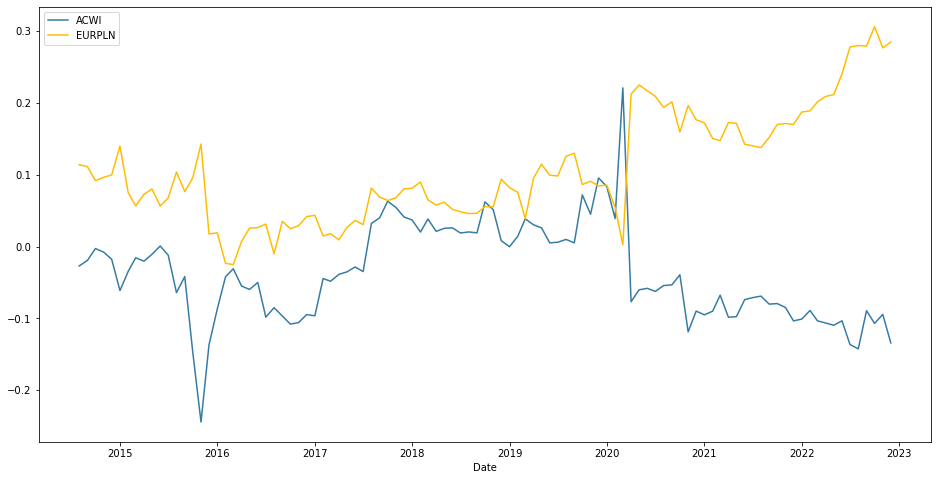

In [6]:
moving_corr = price_changes.iloc[-150:][['ACWI']].rolling(50).corr(price_changes['Mwig40tr'])
moving_corr60 = price_changes.iloc[-150:][['EURPLN']].rolling(50).corr(price_changes['ACWI'])
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

<AxesSubplot:xlabel='Date'>

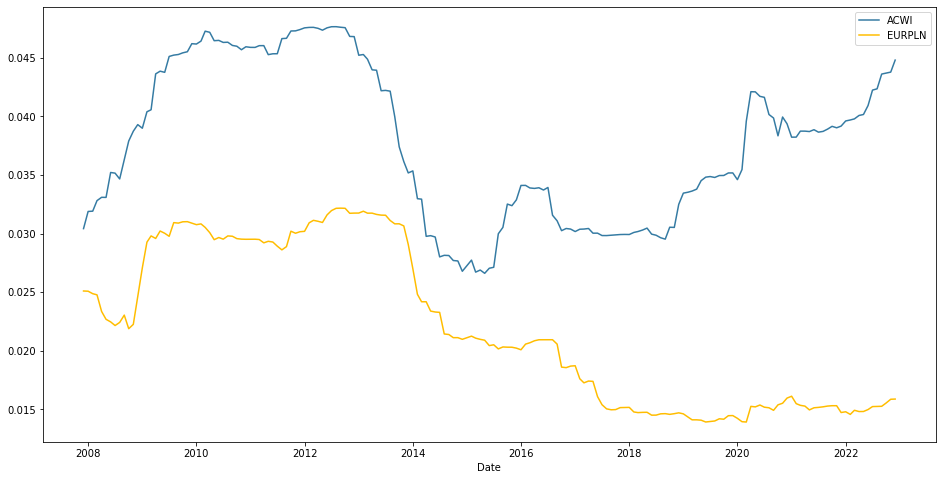

In [7]:
moving_corr = price_changes.iloc[-240:][['ACWI']].rolling(60).std()
moving_corr60 = price_changes.iloc[-240:][['EURPLN']].rolling(60).std()
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

In [8]:
euro_assets = ['ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels']
pln_assets = ['Mwig40tr', 'TBSP', 'EDO']

pln = merged[euro_assets].apply(lambda x: x * merged['EURPLN'])
pln_chng = pln.pct_change()
pln_chng.set_index(merged['Date'], inplace=True)
pln_chng = pd.merge(price_changes[pln_assets], pln_chng, left_index=True, right_index=True)

In [9]:
#pln_chng.to_excel('pln_price_changes2.xlsx')
pln_chng.to_csv('pln_price_changes2.csv', float_format='%.3f')

In [10]:
assets = pln_chng
assets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 1985-01-01 to 2022-12-01
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mwig40tr             155 non-null    float64
 1   TBSP                 191 non-null    float64
 2   EDO                  225 non-null    float64
 3   ACWI                 254 non-null    float64
 4   GovBondG7            254 non-null    float64
 5   GlobalCorporate      123 non-null    float64
 6   Gold                 254 non-null    float64
 7   GABHDG               61 non-null     float64
 8   EURO_STOXX_Leverage  252 non-null    float64
 9   Fallen_Angels        78 non-null     float64
dtypes: float64(10)
memory usage: 55.4 KB


In [11]:
def annullised_mean(series):
    return np.mean(series)*12

def annullised_std(series):
    return np.std(series) * np.sqrt(12)

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weightsDf, means):  
    weights = weightsDf
    return np.sum(weights * means)

def portfolioMeasures(weights,means,cov_table):
    mu = np.apply_along_axis(pmean,1,weights, means=means)
    std = np.apply_along_axis(pstd,1,weights, cov_matrix=cov_table) 
    return np.array([mu,std]).T

In [12]:
native = price_changes.iloc[-150:].agg(['mean', np.std])
native.iloc[0,:] = native.iloc[0,:]*12
native.iloc[1,:] = native.iloc[1,:] * np.sqrt(12)
native


,GovBondG7,ACWI,Mwig40tr,TBSP,EURPLN,Euro_Corporate_Bond,EDO,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,1.41%,10.94%,8.38%,3.07%,1.29%,3.19%,3.53%,3.13%,5.32%,-1.38%,14.84%,6.32%
std,7.62%,12.60%,17.63%,4.40%,6.14%,3.69%,0.55%,6.75%,15.42%,6.29%,34.41%,8.50%


In [13]:
price_changes.iloc[-150:].corr(method='pearson')


,GovBondG7,ACWI,Mwig40tr,TBSP,EURPLN,Euro_Corporate_Bond,EDO,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
GovBondG7,100.00%,0.59%,-9.45%,-8.15%,3.55%,14.67%,-16.39%,79.19%,43.55%,24.68%,-28.91%,31.68%
ACWI,0.59%,100.00%,-6.74%,-7.66%,16.14%,49.71%,-3.54%,54.87%,-1.83%,31.69%,79.54%,77.30%
Mwig40tr,-9.45%,-6.74%,100.00%,6.49%,-56.05%,-4.70%,-2.44%,-6.76%,-6.70%,4.95%,-4.24%,-2.60%
TBSP,-8.15%,-7.66%,6.49%,100.00%,-16.81%,5.18%,-5.99%,-8.09%,-2.93%,6.34%,-8.04%,-0.57%
EURPLN,3.55%,16.14%,-56.05%,-16.81%,100.00%,0.18%,0.91%,14.41%,-5.63%,3.36%,11.31%,25.49%
Euro_Corporate_Bond,14.67%,49.71%,-4.70%,5.18%,0.18%,100.00%,0.96%,61.97%,16.92%,33.41%,41.82%,74.31%
EDO,-16.39%,-3.54%,-2.44%,-5.99%,0.91%,0.96%,100.00%,-17.61%,-4.14%,-17.46%,4.64%,-10.04%
GlobalCorporate,79.19%,54.87%,-6.76%,-8.09%,14.41%,61.97%,-17.61%,100.00%,35.42%,37.72%,32.77%,83.58%
Gold,43.55%,-1.83%,-6.70%,-2.93%,-5.63%,16.92%,-4.14%,35.42%,100.00%,21.00%,-21.57%,5.96%
GABHDG,24.68%,31.69%,4.95%,6.34%,3.36%,33.41%,-17.46%,37.72%,21.00%,100.00%,36.77%,29.09%


In [14]:
perf60 = assets.iloc[-60:].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,2.32%,0.00%,4.43%,11.67%,2.38%,4.06%,11.94%,0.80%,15.18%,8.49%
std,21.69%,5.83%,0.58%,18.02%,8.12%,9.34%,12.30%,8.55%,40.21%,12.23%


In [15]:
perf60 = assets.loc['01-11-2017':'01-12-2021'].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,3.25%,4.85%,2.89%,11.50%,2.83%,4.25%,9.31%,6.88%,14.45%,8.28%
std,20.76%,1.76%,0.27%,16.40%,7.83%,9.16%,11.93%,6.85%,37.74%,12.19%


In [16]:
corr60 = assets.iloc[-60:].corr(method='pearson')
#corr60 = assets.iloc[-60:].cov()
corr60.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,4.29%,1.81%,-30.80%,-41.21%,-38.10%,-22.17%,-37.96%,-17.20%,-34.14%
TBSP,4.29%,100.00%,-11.19%,-5.04%,-4.58%,-2.29%,6.80%,8.64%,-11.49%,4.13%
EDO,1.81%,-11.19%,100.00%,-5.86%,-26.96%,-17.48%,-13.98%,-14.08%,7.61%,-9.33%
ACWI,-30.80%,-5.04%,-5.86%,100.00%,37.32%,70.60%,9.68%,57.11%,83.57%,83.90%
GovBondG7,-41.21%,-4.58%,-26.96%,37.32%,100.00%,85.02%,47.04%,59.25%,4.40%,62.18%
GlobalCorporate,-38.10%,-2.29%,-17.48%,70.60%,85.02%,100.00%,38.44%,66.15%,41.59%,91.47%
Gold,-22.17%,6.80%,-13.98%,9.68%,47.04%,38.44%,100.00%,39.38%,-17.38%,30.07%
GABHDG,-37.96%,8.64%,-14.08%,57.11%,59.25%,66.15%,39.38%,100.00%,44.68%,61.17%
EURO_STOXX_Leverage,-17.20%,-11.49%,7.61%,83.57%,4.40%,41.59%,-17.38%,44.68%,100.00%,58.81%
Fallen_Angels,-34.14%,4.13%,-9.33%,83.90%,62.18%,91.47%,30.07%,61.17%,58.81%,100.00%


In [17]:
perf120 = assets.iloc[-120:].agg(['mean', np.std])
perf120.iloc[0,:] = perf120.iloc[0,:]*12
perf120.iloc[1,:] = perf120.iloc[1,:] * np.sqrt(12)
perf120

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,9.26%,1.90%,3.26%,12.81%,2.56%,4.72%,5.43%,0.69%,17.54%,7.54%
std,17.89%,4.73%,0.59%,15.21%,8.94%,9.33%,15.28%,8.48%,35.24%,11.28%


In [18]:
corr120 = assets.iloc[-120:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr120.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,4.09%,-2.53%,-26.05%,-35.52%,-34.43%,-29.45%,-37.71%,-13.60%,-29.83%
TBSP,4.09%,100.00%,-12.85%,-9.22%,-15.34%,-12.34%,-7.32%,8.52%,-9.96%,-0.25%
EDO,-2.53%,-12.85%,100.00%,-2.09%,-14.90%,-10.80%,-5.09%,-13.41%,5.30%,-4.69%
ACWI,-26.05%,-9.22%,-2.09%,100.00%,40.48%,69.42%,16.35%,57.15%,81.87%,84.21%
GovBondG7,-35.52%,-15.34%,-14.90%,40.48%,100.00%,89.02%,55.72%,59.24%,8.83%,64.17%
GlobalCorporate,-34.43%,-12.34%,-10.80%,69.42%,89.02%,100.00%,47.14%,66.16%,40.62%,91.53%
Gold,-29.45%,-7.32%,-5.09%,16.35%,55.72%,47.14%,100.00%,39.48%,-4.66%,32.20%
GABHDG,-37.71%,8.52%,-13.41%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%
EURO_STOXX_Leverage,-13.60%,-9.96%,5.30%,81.87%,8.83%,40.62%,-4.66%,44.77%,100.00%,59.90%
Fallen_Angels,-29.83%,-0.25%,-4.69%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%


In [19]:
perf180 = assets.iloc[-150:].agg(['mean', np.std])
perf180.iloc[0,:] = perf180.iloc[0,:]*12
perf180.iloc[1,:] = perf180.iloc[1,:] * np.sqrt(12)
perf180

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,8.38%,3.07%,3.53%,12.37%,2.72%,4.44%,6.56%,0.69%,16.38%,7.54%
std,17.63%,4.40%,0.55%,15.03%,9.98%,9.25%,16.38%,8.48%,35.90%,11.28%


In [20]:
corr180 = assets.iloc[-150:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr180.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,6.49%,-2.44%,-29.47%,-41.78%,-34.82%,-27.75%,-37.71%,-14.29%,-29.83%
TBSP,6.49%,100.00%,-5.99%,-13.44%,-16.44%,-13.38%,-8.90%,8.52%,-10.80%,-0.25%
EDO,-2.44%,-5.99%,100.00%,-2.38%,-12.09%,-11.51%,-3.81%,-13.41%,4.69%,-4.69%
ACWI,-29.47%,-13.44%,-2.38%,100.00%,35.53%,69.42%,17.75%,57.15%,79.19%,84.21%
GovBondG7,-41.78%,-16.44%,-12.09%,35.53%,100.00%,88.76%,52.15%,59.24%,-3.26%,64.17%
GlobalCorporate,-34.82%,-13.38%,-11.51%,69.42%,88.76%,100.00%,47.66%,66.16%,40.27%,91.53%
Gold,-27.75%,-8.90%,-3.81%,17.75%,52.15%,47.66%,100.00%,39.48%,-9.23%,32.20%
GABHDG,-37.71%,8.52%,-13.41%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%
EURO_STOXX_Leverage,-14.29%,-10.80%,4.69%,79.19%,-3.26%,40.27%,-9.23%,44.77%,100.00%,59.90%
Fallen_Angels,-29.83%,-0.25%,-4.69%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%


<AxesSubplot:xlabel='Date'>

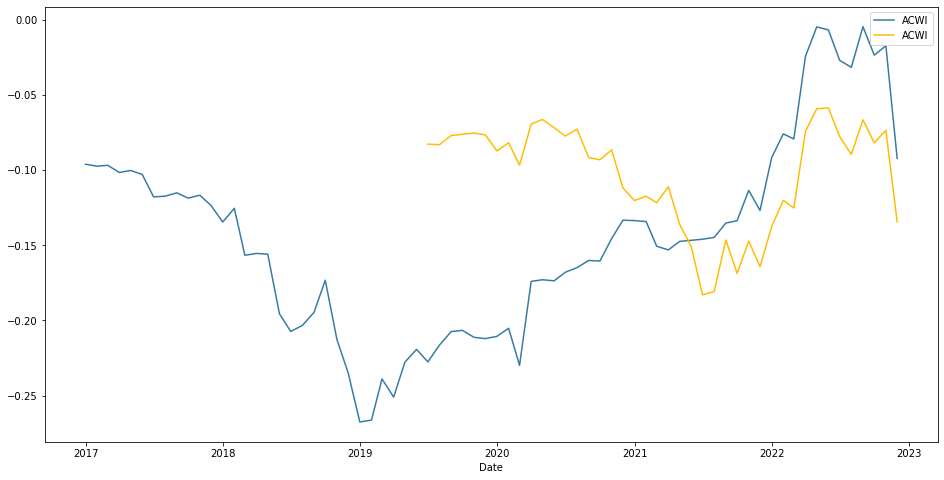

In [21]:
moving_corr = assets[['ACWI']].rolling(120).corr(assets['TBSP'])
moving_corr60 = assets[['ACWI']].rolling(150).corr(assets['TBSP'])
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

In [22]:
portfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'EURO_STOXX_Leverage', 'EDO']]
means = pd.DataFrame(portfolio_assets.mean()*12)
cov = pd.DataFrame(portfolio_assets.cov())
portfolio_assets['01-01-2003':'01-01-2004']
portfolio_assets['01-12-2017':'01-12-2021']

,Mwig40tr,TBSP,ACWI,Gold,EURO_STOXX_Leverage,EDO
Date,,,,,,
2017-02-01,10.14%,-0.13%,2.40%,3.07%,3.85%,0.10%
2017-03-01,4.24%,0.39%,0.03%,-2.09%,11.27%,0.10%
2017-04-01,-1.99%,1.33%,-2.35%,-2.23%,2.14%,0.10%
2017-05-01,2.48%,0.32%,-0.48%,-2.73%,2.61%,0.10%
2017-06-01,-0.44%,0.96%,-2.20%,-4.52%,-6.82%,0.10%
2017-07-01,2.74%,0.15%,1.26%,0.48%,1.74%,0.12%
2017-08-01,1.03%,0.10%,0.14%,3.19%,-0.98%,0.12%
2017-09-01,-0.05%,0.52%,1.97%,-2.18%,10.43%,0.12%
2017-10-01,1.64%,-0.02%,5.16%,1.96%,6.21%,0.17%


In [23]:
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels', 'EDO']
#['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO]

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO']]
port = rp.Portfolio(porfolio_assets[-123:])



means = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].mean()*12)
cov = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].cov())

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 15 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MV' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head(50))




NameError: name 'rp' is not defined

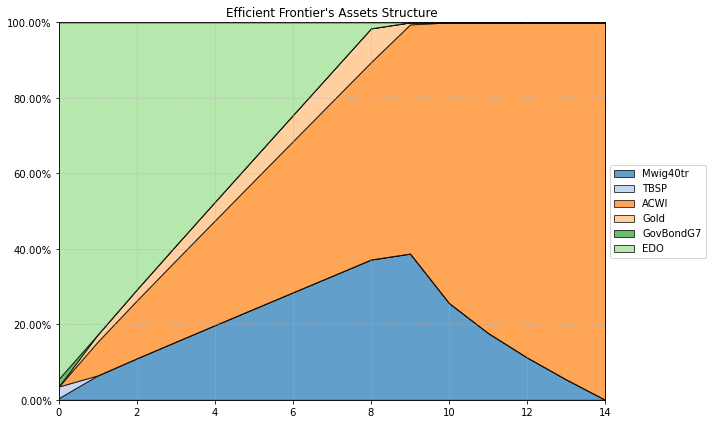

In [ ]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [ ]:
porfolio_assets[-150:].cov().to_numpy()
frontier.values.T
porfolio_assets[-150:].mean().values.T*12

array([0.0838378 , 0.03067022, 0.12365509, 0.06559336, 0.02720226,
       0.03527836])

In [ ]:
measures = portfolioMeasures(frontier.values.T,porfolio_assets[-150:].mean().values.T, porfolio_assets[-150:].cov().to_numpy())
measures[:,0] = measures[:,0]*12
measures[:,1] = measures[:,1]*np.sqrt(12)

measures

array([[0.03519068, 0.00528686],
       [0.0469084 , 0.01548693],
       [0.05505872, 0.02569391],
       [0.06301184, 0.03588331],
       [0.07090147, 0.04606665],
       [0.07876275, 0.05624732],
       [0.08660875, 0.06642652],
       [0.09444595, 0.07660495],
       [0.10227776, 0.08678306],
       [0.10792318, 0.09652981],
       [0.11345244, 0.10751325],
       [0.11660844, 0.11831416],
       [0.1191954 , 0.12902325],
       [0.12150745, 0.13967592],
       [0.12365509, 0.15028918]])

,Mwig40tr,TBSP,ACWI,Gold,GovBondG7,EDO
Mwig40tr,0.26%,0.00%,-0.07%,-0.07%,-0.06%,-0.00%
TBSP,0.00%,0.02%,-0.01%,-0.01%,-0.01%,-0.00%
ACWI,-0.07%,-0.01%,0.19%,0.04%,0.04%,-0.00%
Gold,-0.07%,-0.01%,0.04%,0.22%,0.07%,-0.00%
GovBondG7,-0.06%,-0.01%,0.04%,0.07%,0.08%,-0.00%
EDO,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,0.00%


In [24]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)*np.sqrt(12)

def pmean(weightsDf, means):  
    weights = weightsDf
    return weights.dot(means) *12



def optimize(expectedMean, means: np.array, cov_table: np.array):

    constraint1 = NonlinearConstraint(lambda x : x.sum(),1,1)
    constraint2 = NonlinearConstraint(lambda x: x.dot(means)*12, expectedMean, expectedMean)
    constraint3 = NonlinearConstraint(lambda x: np.all(np.any([x >=0.05, x == 0], axis=0)).astype(int),True,True)
    assets_constraints = [(0.0,1),(0.0,1), (0,0.09)]
    obj = lambda x: x.T@cov_table@x
    start = [1/len(means) for n in range(len(means))]
    result = minimize(obj,start,constraints=[constraint1, constraint2],bounds=assets_constraints)
    #result = np.append(result.x, [expectedMean], [result.fun])    

    return np.array(result.x)

In [27]:

#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels', 'EDO']
#['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO', 'GlobalCorporate', 'EURO_STOXX_Leverage']
assets_names = ['TBSP', 'ACWI']

portfolio = assets.iloc[-180:][assets_names]
means = portfolio.mean()
cov_table = portfolio.cov()
stds = portfolio.std()


print(means*12)
print(cov_table)
print(stds*np.sqrt(12))


TBSP    3.68%
ACWI   10.39%
dtype: float64
       TBSP   ACWI
TBSP  0.02% -0.00%
ACWI -0.00%  0.21%
TBSP    4.39%
ACWI   15.81%
dtype: float64


In [73]:
ret = np.random.multivariate_normal(means, cov_table,36)
np.round(np.cov(ret),3)
return_table = np.zeros((10000,36,2))
for n in range(10000):
    return_table[n] = np.random.multivariate_normal(means, cov_table,36)

means_ret = return_table.sum(0)/10000
means_ret.mean(0)


array([0.00305465, 0.00871509])

In [26]:
mu_min = means[0]*12 #means.min()*12
mu_max = 0.12 #means.max()*12

portfolio_means = np.linspace(mu_min, mu_max, 12)

weights = np.empty((0,len(assets_names)+2))
for mean in portfolio_means:
    weight = optimize(mean,means,cov_table)
    std = pstd(weight,cov_table)
    weight = np.append(weight, [mean, std])
    weights = np.append(weights, [weight], axis=0)

columns = np.append(assets_names, ['mu', 'std'])
ef = pd.DataFrame(weights, columns=columns) 
ef





ValueError: operands could not be broadcast together with shapes (2,) (3,) (3,) 

In [ ]:
minimal_weights = lambda x: np.all((np.any([x >=0.05, x == 0], axis=0))).astype(int)

weights = np.array([0, 0.051, 0.5, 0.04])

minimal_weights(weights)

0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


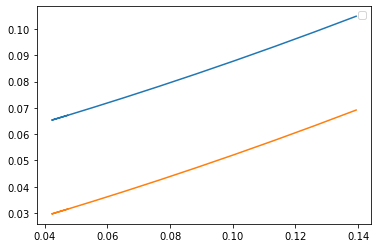

In [ ]:
W0 = 30000
WT1 = 50000
WT2 = 35000

t = 10
p = 0.999 #target propability
std = 0.09
mu = lambda std, WT: (1/t)*np.log(WT/W0) + p/np.sqrt(t)*std + 0.5*std**2

stds = ef['std']

mus1 = [mu(std, WT1) for std in stds ]

mus2 = [mu(std, WT2) for std in stds ]

plt.plot(stds, mus1)
plt.plot(stds, mus2)
plt.legend()
plt.show()




In [ ]:
def shrinkedCovariance(returns: pd.DataFrame, w: int):
    std = np.diag(returns.std())*np.sqrt(12)
    corr = returns.corr('pearson')
    shrinked_corr = (1-w)*corr + np.ones_like(corr)*w 
    result = std @ shrinked_corr @ std
    return std,corr, shrinked_corr, result

def pstd(cov_matrix, weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

assets_names = ['TBSP', 'ACWI']

portfolio_returns = assets.iloc[-120:][assets_names]

std, corr, sh_corr, res = shrinkedCovariance(portfolio_returns,0.5)
cov = portfolio_returns.cov()*12

print (portfolio_returns.cov()*12)
print(std)
print(corr)
print(sh_corr)
print(res)
print('---')
print(pstd(cov, np.array([0.4, 0.6])))
print('---')
print(pstd(res, np.array([0.4, 0.6])))

#print(computed_std)


       TBSP   ACWI
TBSP  0.22% -0.07%
ACWI -0.07%  2.31%
[[0.04725282 0.        ]
 [0.         0.15208061]]
        TBSP    ACWI
TBSP 100.00%  -9.22%
ACWI  -9.22% 100.00%
        TBSP    ACWI
TBSP 100.00%  45.39%
ACWI  45.39% 100.00%
      0     1
0 0.22% 0.33%
1 0.33% 2.31%
---
0.09146392619858458
---
0.10123873094081719


In [ ]:
ret = assets.iloc[-60:][assets_names]
ret_24 = assets.iloc[-84:-24][assets_names]
ret_48 = assets.iloc[-108:-48][assets_names]
print(ret.std()*np.sqrt(12))
print(ret_24.std()*np.sqrt(12))
print(ret_48.std()*np.sqrt(12))
print('---')

std, corr, sh_corr, res = shrinkedCovariance(ret,0)
std, corr, sh_corr, res_24 = shrinkedCovariance(ret_24,0)
std, corr, sh_corr, res_48 = shrinkedCovariance(ret_48,0)


print(pstd(res, np.array([0.4, 0.6])))
print(pstd(res_24, np.array([0.4, 0.6])))
print(pstd(res_48, np.array([0.4, 0.6])))


print('---')
std, corr, sh_corr, res = shrinkedCovariance(ret,0.75)
std, corr, sh_corr, res_24 = shrinkedCovariance(ret_24,0.75)
std, corr, sh_corr, res_48 = shrinkedCovariance(ret_48,0.75)


print(pstd(res, np.array([0.4, 0.6])))
print(pstd(res_24, np.array([0.4, 0.6])))
print(pstd(res_48, np.array([0.4, 0.6])))


TBSP    5.83%
ACWI   18.02%
dtype: float64
TBSP    1.97%
ACWI   15.60%
dtype: float64
TBSP    2.47%
ACWI   12.93%
dtype: float64
---
0.10942527346768507
0.09450573239453121
0.07687067421906144
---
0.126273078746576
0.09980622208789802
0.08496410489639229


In [ ]:
from scipy.stats import norm
mean = 0.0362
std = 0.15
W0 = 100
W1 = 105.62
h = 1

def prob2(W0, W1, mean, std, h):
    return 1-norm.cdf((np.log(W1/W0)-(mean-0.5*std**2)*h)/(std*np.sqrt(h)))

np.round(prob2(W0,W1,mean, std, 1),3)




0.421

In [ ]:
VT, l, k = calculateValues()
l = [0,0,1,1,2]
k = [0,0,0,1,2]


NameError: name 'calculateValues' is not defined

In [ ]:
arr1 = np.array([[1,2,4,5], [1,2,4,5]])
arr2 = np.array([[2],[4]])
np.where(arr1 >= arr2, arr2, 0)

array([[0, 2, 2, 2],
       [0, 0, 4, 4]])

In [ ]:
def __prob2(W0, W1, mean, std, h):
    return norm.pdf((np.log(W1/W0)-(mean-0.5*std**2)*h)/(std*np.sqrt(h)))
W0 = 1001
W1 = 1200
m = 0.1
std = 0.15
__prob2(W0,W1,m,std,h=1)

0.32976540555225764

In [ ]:
def get_strategy_for_wealth_value(WT, portfolio_strategies, Wti):
    difference = np.absolute(WT - Wti)
    index_minx_value = np.argmin(difference)
    return portfolio_strategies[index_minx_value]

portfolio_strategies = [2, 2, 1, 0, 0, 0]
WT = np.array([49,50,60, 80, 100,105])
Wti = 105 - 40
get_strategy_for_wealth_value(WT, portfolio_strategies, Wti)



1

In [ ]:
arr = np.array([[1,2], [3,4], [5,6]])
np.linalg.matrix_rank(arr)



2

In [ ]:
def WMax(t,W0, infusions, meanMax,stdMin,stdMax):
    valueOfInfusions = 0
    for i in range(t):
        valueOfInfusions += infusions[i]*np.exp((meanMax - (stdMin**2)/2)*(t-i) + (3*stdMax*np.sqrt(t-i)))
                                                           
    return W0*np.exp((meanMax-(stdMin**2/2))*t + 3*stdMax*np.sqrt(t)) + valueOfInfusions

def WMin(t, W0, infusions, goals, meanMin, stdMin, stdMax):
    valueOfInfusions = 0
    for i in range(t+1):
        valueOfInfusions += (infusions[i]-goals[i])*np.exp((meanMin - (stdMin**2)/2)*(t-i) - (3*stdMax*np.sqrt(t-i)))

    return W0*np.e**((meanMin-stdMax**2/2)*t - 3*stdMax*np.sqrt(t)) + valueOfInfusions


def deductE(row, logW0):
    diff = row - logW0
    e = diff[diff >= 0].min()
    return row - e

def generateGrid(W0, T, iMax, infusions, goals, minMean, minStd, maxMean, maxStd) ->np.array:
    grid = np.zeros((T,iMax))
    logW0 = np.log(W0)
    Wmin = 1
    for t in range(1,T+1):
        wMin = WMin(t,W0,infusions,goals, minMean,minStd,maxStd)
        wMin = Wmin if wMin < Wmin else wMin
        wMax = WMax(t,W0, infusions, maxMean,minStd, maxStd)
        row = np.linspace(np.log(wMin),np.log(wMax),iMax)
        row = deductE(row,logW0)
        grid[t-1] = row
    return np.exp(grid)


def calculateTransitionPropabilities(portfolioMeasures, W0: int, W1: np.array, infusions, costs, h=1):
    mean = portfolioMeasures[0]
    std = portfolioMeasures[1]
    p = norm.pdf((np.log(W1/(W0+infusions-costs))-(mean-0.5*std**2)*h)/(std*np.sqrt(h)))
    return p/p.sum()

def calculateValuesForLastPeriod(W: np.array, k: np.array):
    values = np.zeros((len(k), len(W)))
    for i in range(len(k)):
        values[i] = np.where(W >= k[i,0], k[i,1], 0 )
    return np.amax(values, axis=0)

In [ ]:
portfolios = np.array([[0.0526, 0.0374], [0.07059443, 0.103057], [0.0886, 0.1954]])
W0 = 10
T = 12
#infusions = [0,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000]
infusions = np.zeros(13)
goals = [0,0,0,0,0,0,0,100,0,0,0,0,150]
iMax = 500

grid = generateGrid(W0,T,iMax, infusions, goals, portfolios[0,0], portfolios[0,1], portfolios[2,0], portfolios[2,1])

gridT = grid.T

In [ ]:
arr = [1,2,3,4,5]
arr2 = [4,5,6,7,8]
np.sqrt(np.var(arr))
np.std(arr)
np.mean(arr)
np.cov(arr,arr2)[0,1]/(np.std(arr)*np.std(arr2))


1.2499999999999998

In [ ]:
def calculateTransitionPropabilitiesForAllPorfolios(portfolios,WT,WT1,infusions, h=1):
    l = len(portfolios)
    i = len(WT)
    b = (portfolios[:,0]-0.5*portfolios[:,1]**2)*h
    bi = np.repeat(b, i).reshape(l*i,1)
    c = portfolios[:,1]*np.sqrt(h)
    ci = np.repeat(c, i).reshape(l*i,1)
   
    Wt1 = np.tile(WT1, (l*i,1))
    Wt = np.tile(WT,(l,1)).reshape(i*l,1)+infusions
    result = norm.pdf((np.log(Wt1/Wt)- bi)/ci).reshape(l,i,len(WT1))
    return result/result.sum(2).reshape(l,i,1)


In [ ]:
def get_portfolios_strategies(VT1, propabilities):
    Vt = VT1 * propabilities
    sums = Vt.sum(2)
    maxes = np.amax(sums,0)
    portfolios_ids = np.argmax(sums,0)
    chosen_propabilities = 0#np.take(propabilities,portfolios_ids,0)
    return portfolios_ids, maxes, chosen_propabilities

portfolios = np.array([[0.0526, 0.0374], [0.07059443, 0.103057  ], [0.0886, 0.1954]])
WT = np.array([49,50,60,80,100,105])
WT1 = np.array([90,95,100,103,105,110])
VT1 = [0,0,0,100,100,100]
c = 50
#goals = [[50, 80], [30, 50],]
VTc0 = np.array([29.014, 29.55, 77.286, 95.997])

probabilities = calculateTransitionPropabilitiesForAllPorfolios(portfolios,WT,WT1,5,1)
print(np.round(probabilities,3))
""""
portfolios_strategies, VT, chosen_propabilities, V = get_portfolios_strategies(VT1,probabilities)
print(portfolios_strategies)
print(VT)
print(np.round(chosen_propabilities,3))
print(np.round(V,3)) 
"""
porfolios_strategies, VT, chosen_propabilities = get_portfolios_strategies(VT1,probabilities)
print(np.round(porfolios_strategies,1))
print(np.round(VT,1))
print(np.round(chosen_propabilities,2))



[[[1.   0.   0.   0.   0.   0.  ]
  [1.   0.   0.   0.   0.   0.  ]
  [1.   0.   0.   0.   0.   0.  ]
  [0.77 0.22 0.01 0.   0.   0.  ]
  [0.   0.   0.02 0.1  0.24 0.63]
  [0.   0.   0.   0.02 0.07 0.91]]

 [[0.91 0.08 0.01 0.   0.   0.  ]
  [0.9  0.09 0.01 0.   0.   0.  ]
  [0.77 0.18 0.04 0.01 0.01 0.  ]
  [0.28 0.26 0.18 0.13 0.1  0.05]
  [0.03 0.08 0.16 0.21 0.24 0.29]
  [0.02 0.05 0.13 0.2  0.24 0.36]]

 [[0.47 0.24 0.12 0.08 0.06 0.03]
  [0.46 0.24 0.12 0.08 0.06 0.03]
  [0.35 0.24 0.15 0.11 0.09 0.05]
  [0.2  0.19 0.18 0.16 0.15 0.12]
  [0.11 0.14 0.17 0.18 0.19 0.2 ]
  [0.09 0.13 0.17 0.19 0.2  0.22]]]
[2 2 2 2 0 0]
[16.4 17.2 25.9 43.6 98.3 99.9]
0
